## **Project** **Title**: **Gas** **Power** **Generation** **Forecasting** **Using** **XGBoost** **and** **LSTM**

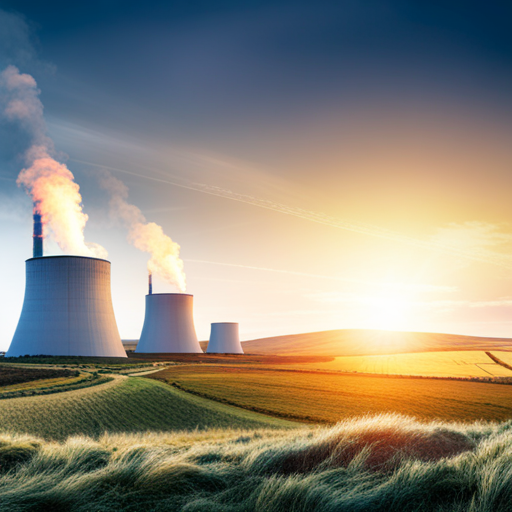

Power generation from gas is a significant source of NO2 and PM emissions in UK. As the UK's energy mix becomes more reliant on renewable energy sources, the need for accurate gas generation forecasting is more important than ever. The sporadic nature of renewable energy sources mean that they do not always produce electricity when it is needed. Gas power plants are used to balance the grid and ensure that there is always enough electricity available to meet demand.

Accurate gas generation forecasting also helps to ensure that gas power plants are only used when necessary, reducing the amount of greenhouse gases emitted from the gas plants. It also helps to improve grid reliability, by knowing how much gas power will be available in the future, grid operators can make better decisions about how to manage the grid as well as reduce costs.

This project aims to explore time series forecasting of gas power generation in the UK, using two different methods.

## XGBoost

eXtreme Gradient Boosting is a machine learning algorithm following the gradient boosting framework, where weak learners (decision trees) are sequentially trained to correct the mistakes made by the previous models. This iterative process helps improve the overall model performance.

It takes in the following general parameters:

> a. boosters: 'gbtree' for tree-based model or 'gblinear for linear models

> b. n_estimators: The number of boosting rounds(i.e., the number of trees to build)

> c. learning rate: The learning rate or shrinkage factor, which controls the impact of each tree on the final prediction

> d. max_depth: The maximum depth of a tree. It controls the complexity of the tree and helps prevent overfitting

> e. early_stopping_rounds : The number of rounds without improvement in evaluation metric to trigger early stopping

> f. objective: The objective function to optimise during training, such as "reg:linear" for regression or "binary:logistic" for binary classification.

 XGBoost is used to forecast a period of two weeks of hourly gas production.








In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

### Loading the Data

To accomplish this, data has been extracted from the [Modo Energy Platform](https://https://platform.modo.energy/data?sections=Grid)

Our data shows the total power generated by gas in MWs by both CCGT(Combined Cycle Gas Turbine) and OCGT(Open Cycle Gas Turbine) in UK for the time period 24th Jun 22' to 25th Jun 23'


In [3]:
class TimeSeriesForecaster:
    
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self._prepare_data()
        
    # Function to convert the timestamp format
    
    def convert_hour(self,row):
        Hour = row['Timestamp']  # Use the correct column name
        datetime_obj = datetime.strptime(Hour, "%Y-%m-%dT%H:%M:%S%z")
        formatted_datetime = datetime_obj.strftime("%Y-%m-%d %H:%M")
        
        return formatted_datetime
    
    def _prepare_data(self):
         # Applying the function to our dataset
        self.df['Timestamp'] = self.df.apply(self.convert_hour, axis=1)
        self.df.rename(columns={'Timestamp':'Hour'}, inplace=True)
        self.df['Hour'] = pd.to_datetime(self.df['Hour'])
        self.df.set_index('Hour', inplace=True)
        self.df.rename(columns={self.df.columns[0]: 'Gas(MWs)'}, inplace=True)
        self.df = self.create_features(self.df)

        self.train = self.df.loc[self.df.index < '06-12-2023']
        self.test = self.df.loc[self.df.index >= '06-12-2023']
        
        # Label encode 'season' before computing season_weighted
        self.le = LabelEncoder()
        self.train['season'] = self.le.fit_transform(self.train['season'])
        self.test['season'] = self.le.transform(self.test['season'])

        # Slicing for features
        self.FEATURES = [
            'hour', 'dayofweek', 'dayofyear', 'dayofmonth', 'month', 
            'season', 'quarter', 'time_index', 'electricity_diff',
            'Gas(MWs)_lag_1', 'Gas(MWs)_lag_2', 'Gas(MWs)_lag_3', 'Gas(MWs)_lag_7',
            'Gas(MWs)_rolling_3', 'Gas(MWs)_rolling_7', 'Gas(MWs)_rolling_14', 'Gas(MWs)_rolling_20'
        ]
        self.TARGET = 'Gas(MWs)'
        
        self.X_train = self.train[self.FEATURES]
        self.y_train = self.train[self.TARGET]
        self.X_test = self.test[self.FEATURES]
        self.y_test = self.test[self.TARGET]

    def create_features(self, df, label='Gas(MWs)', lags=[1, 2, 3, 7], rolling_means=[3, 7, 14, 20]):
        df = df.copy()
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['electricity_diff'] = df['Gas(MWs)'].diff()
        df['time_index'] = np.arange(len(df))

        for lag in lags:
                df[f'{label}_lag_{lag}'] = df[label].shift(lag)

        for rm in rolling_means:
               df[f'{label}_rolling_{rm}'] = df[label].shift(1).rolling(window=rm).mean()

        def get_season(row):
            m, d = row.month, row.day
            if (m == 3 and d >= 1) or (m == 4): return 'Spring'
            elif m in [5, 6]: return 'Summer'
            elif m == 7 or m == 8 or (m == 9 and d <= 15): return 'Monsoon'
            elif (m == 9 and d >= 16) or m == 10 or (m == 11 and d <= 15): return 'Fall'
            else: return 'Winter'

        df['season'] = df['date'].apply(get_season)

        return df 

    def plot_exploratory(self, df):

        plt.figure(figsize=(15, 5))
        plt.plot(df.index, df['Gas(MWs)'], label='Gas(MWs)', color='blue')
        plt.title('Electricity Generation Over Time')
        plt.xlabel('Time')
        plt.ylabel('Electricity Generated (MWs)')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print('Feature engineering in time series data requires capturing temporal patterns and dependancies that can affect the target variable. Here we will create the features like date, hour, day of week, weekday, quarter, month, year, day of year, week of year and season which can explain the trends of power generation data')
        
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        sns.boxplot(data=df, x='hour', y='Gas(MWs)', ax=axs[0, 0])
        axs[0, 0].set_title('Electricity Generated by Day of Week')

        sns.boxplot(data=df, x='season', y='Gas(MWs)', ax=axs[0, 1])
        axs[0, 1].set_title('Electricity Generated by Season')
        
        sns.boxplot(data=df, x='dayofweek', y='Gas(MWs)', ax=axs[1, 0])
        axs[1, 0].set_title('Electricity Generated by Day of Week')

        sns.boxplot(data=df, x='month', y='Gas(MWs)', ax=axs[1, 1])
        axs[1, 1].set_title('Electricity Generated by Month')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x='Gas(MWs)_lag_1', y='Gas(MWs)', alpha=0.5, color='blue')
        plt.title('Electricity Generation vs Lag 1')
        plt.xlabel('Lag 1')
        plt.ylabel('Electricity Generation')
        plt.show()
        print('Training the model')

    def train_model(self):
        self.model = xgb.XGBRegressor(
            n_estimators=1500,
            early_stopping_rounds=30,
            objective='reg:squarederror',
            subsample=0.5,
            colsample_bytree=0.8,
            max_depth=10,
            learning_rate=0.01,
            random_state=42
        )
        self.model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_train, self.y_train), (self.X_test, self.y_test)],
            verbose=100
        )
        self.test['prediction'] = self.model.predict(self.X_test)

    def plot_feature_importance(self):
        fi = pd.DataFrame(
            data=self.model.feature_importances_,
            index=self.model.feature_names_in_,
            columns=['importance']
        )
        fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(10, 6))
        plt.show()

    def plot_predictions(self):
        
        merged = self.df.merge(self.test[['prediction']], how='left', left_index=True, right_index=True)
        ax = merged[['Gas(MWs)']].plot(figsize=(15, 5))
        merged['prediction'].plot(ax=ax, style='.')
        plt.legend(['Truth Data', 'Predictions'])
        plt.title('Actual vs Predictions')
        plt.show()
        print('Forecasting on the test dataset for a period of two weeks : 12th June 2023 to 25th June 2023')
        
        ax = merged.loc[(merged.index > '06-12-2023') & (merged.index < '06-25-2023')]['Gas(MWs)'].plot(figsize=(15, 5), title='Week Of Data')
        merged.loc[(merged.index > '06-12-2023') & (merged.index < '06-25-2023')]['prediction'].plot(style='.')
        plt.legend(['Truth Data','Prediction'])
        plt.show()

        rmse = np.sqrt(mean_squared_error(self.y_test, self.test['prediction']))
        mae = mean_absolute_error(self.y_test, self.test['prediction'])
        print(f'\nEvaluation on Test Set:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n')

        def mean_absolute_percentage_error(y_true, y_pred): 
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            # Avoid division by zero
            nonzero = y_true != 0
            return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

        mape = mean_absolute_percentage_error(self.y_test, self.test['prediction'])
        print(f'Average Percentage Error (MAPE): {mape:.2f}%')

    def compare_predictions(self):
        comparison_df = self.test.copy()
        comparison_df = comparison_df[[self.TARGET, 'prediction']]
        comparison_df.rename(columns={self.TARGET: 'Actual', 'prediction': 'Predicted'}, inplace=True)
        print("\nSample of Predicted vs Actual Values:\n")
        print(comparison_df)
        return comparison_df


/tmp/ipykernel_1129/812772324.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train['season'] = self.le.fit_transform(self.train['season'])
/tmp/ipykernel_1129/812772324.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['season'] = self.le.transform(self.test['season'])


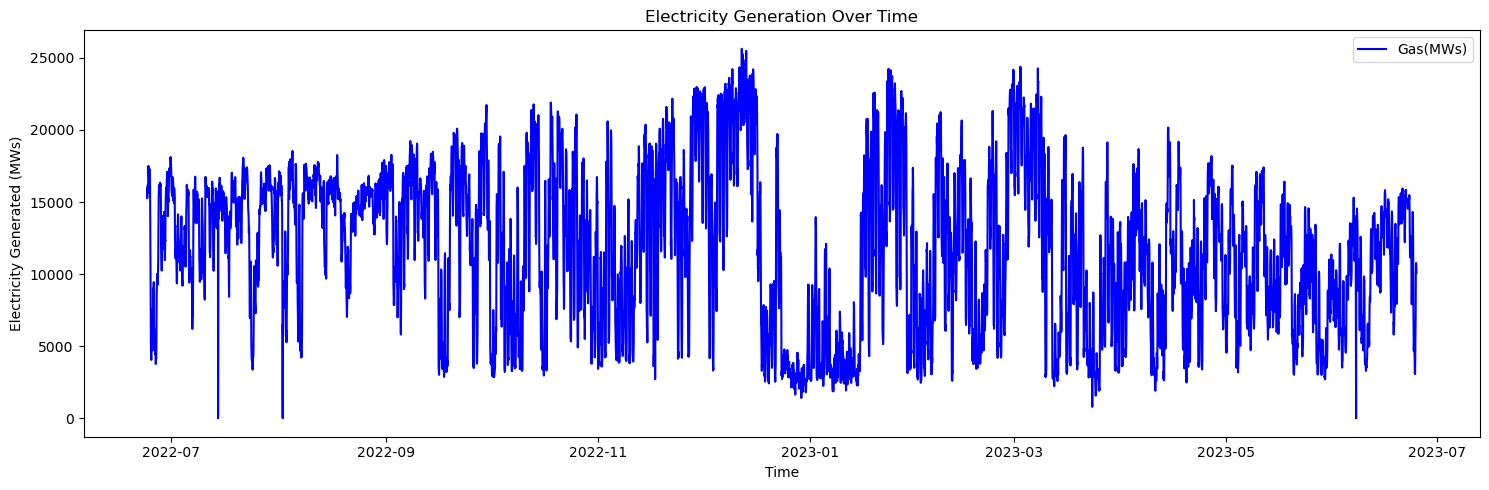

Feature engineering in time series data requires capturing temporal patterns and dependancies that can affect the target variable. Here we will create the features like date, hour, day of week, weekday, quarter, month, year, day of year, week of year and season which can explain the trends of power generation data


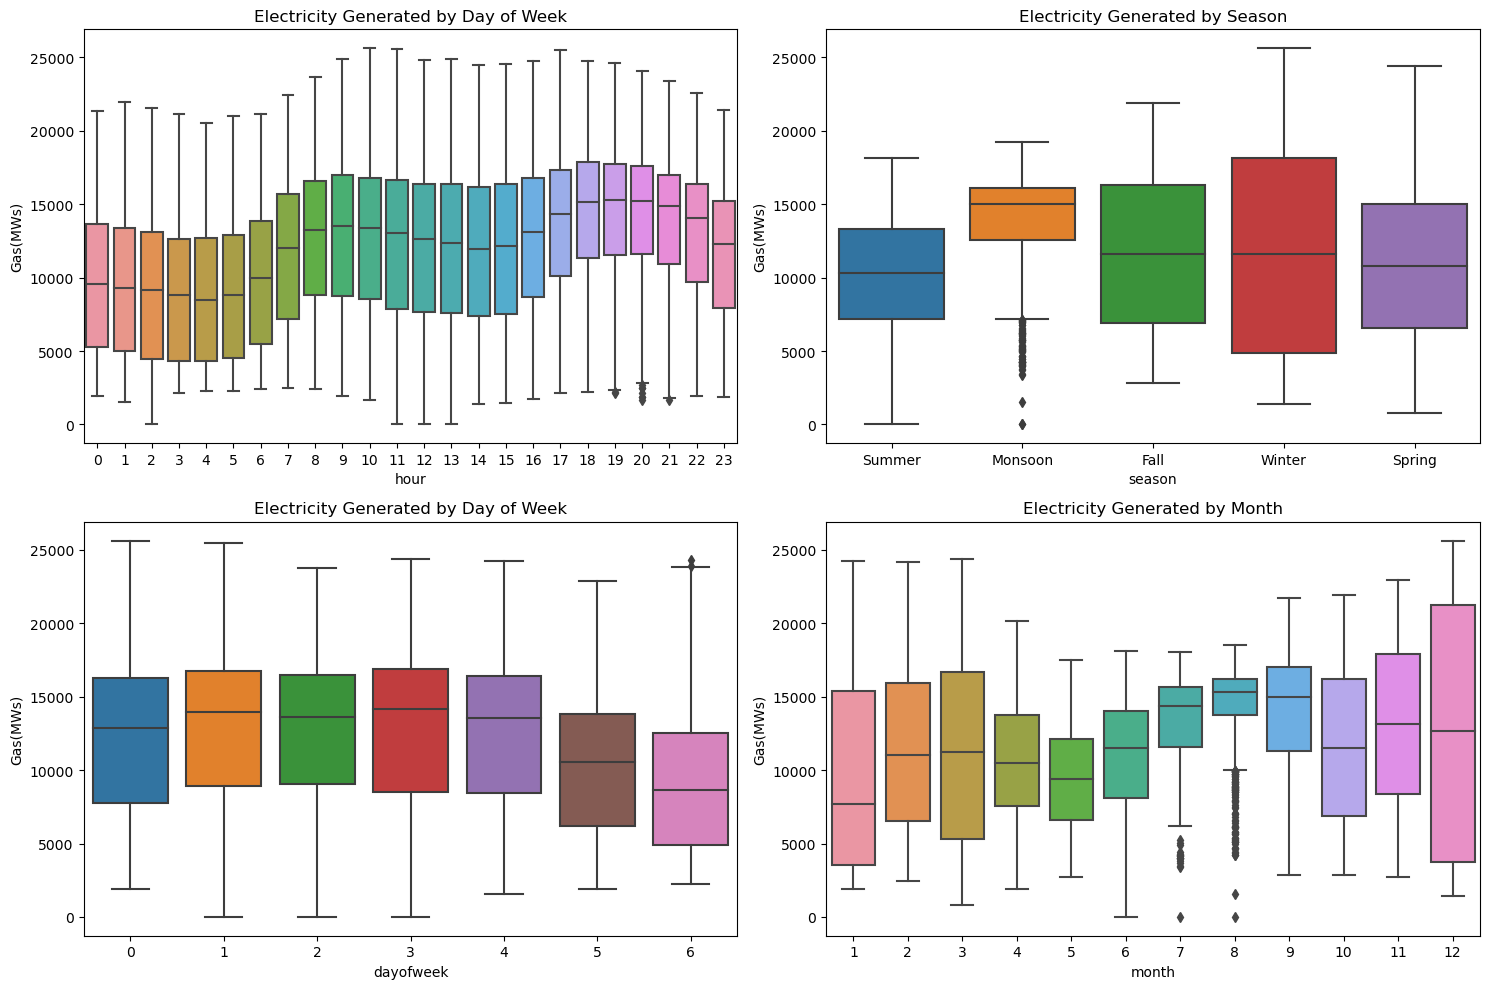

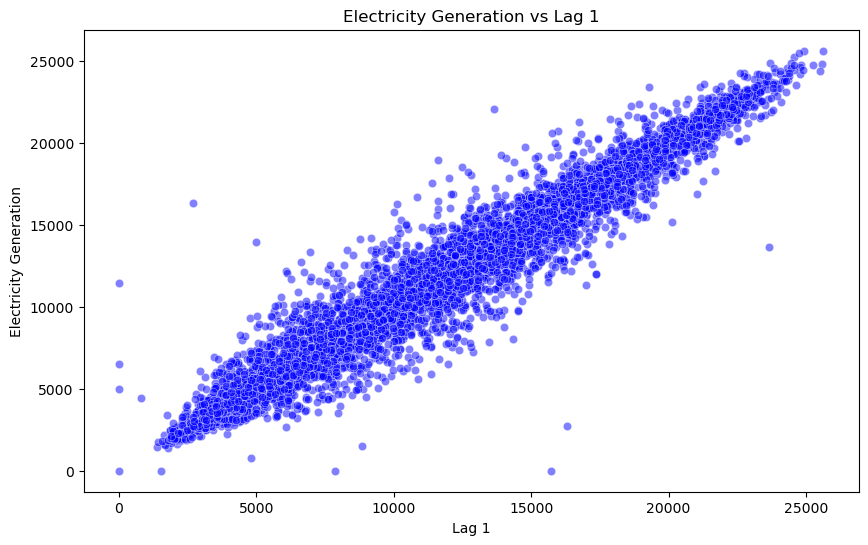

Training the model
[0]	validation_0-rmse:12950.58984	validation_1-rmse:12388.03196
[100]	validation_0-rmse:4817.47792	validation_1-rmse:4541.26347
[200]	validation_0-rmse:1809.23042	validation_1-rmse:1688.07934
[300]	validation_0-rmse:696.14529	validation_1-rmse:653.31192
[400]	validation_0-rmse:285.60933	validation_1-rmse:288.02203
[500]	validation_0-rmse:136.15085	validation_1-rmse:162.03390
[600]	validation_0-rmse:82.30855	validation_1-rmse:119.83387
[700]	validation_0-rmse:61.73774	validation_1-rmse:106.17701
[800]	validation_0-rmse:52.36717	validation_1-rmse:100.97659
[900]	validation_0-rmse:46.99990	validation_1-rmse:98.26329
[1000]	validation_0-rmse:43.41611	validation_1-rmse:95.98144
[1100]	validation_0-rmse:40.49746	validation_1-rmse:94.25225
[1200]	validation_0-rmse:37.91897	validation_1-rmse:92.65920
[1214]	validation_0-rmse:37.60502	validation_1-rmse:92.74742


/tmp/ipykernel_1129/812772324.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['prediction'] = self.model.predict(self.X_test)


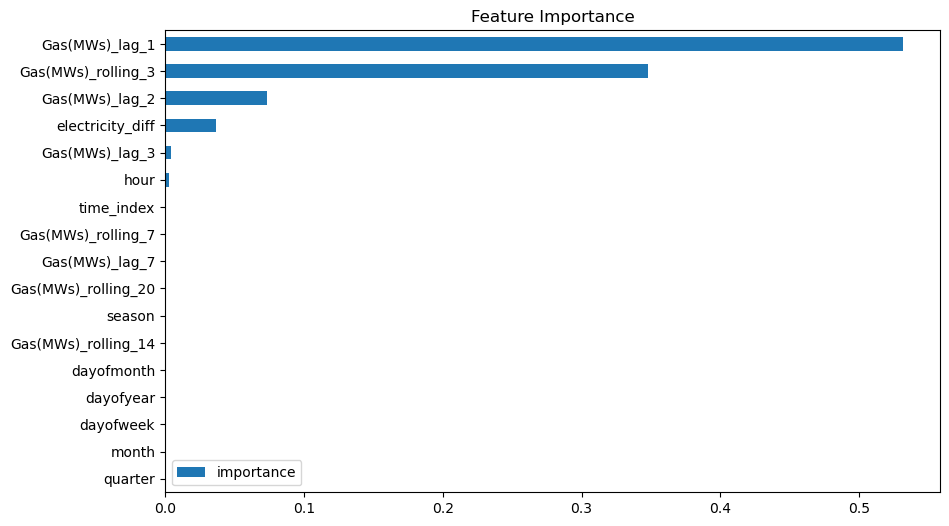

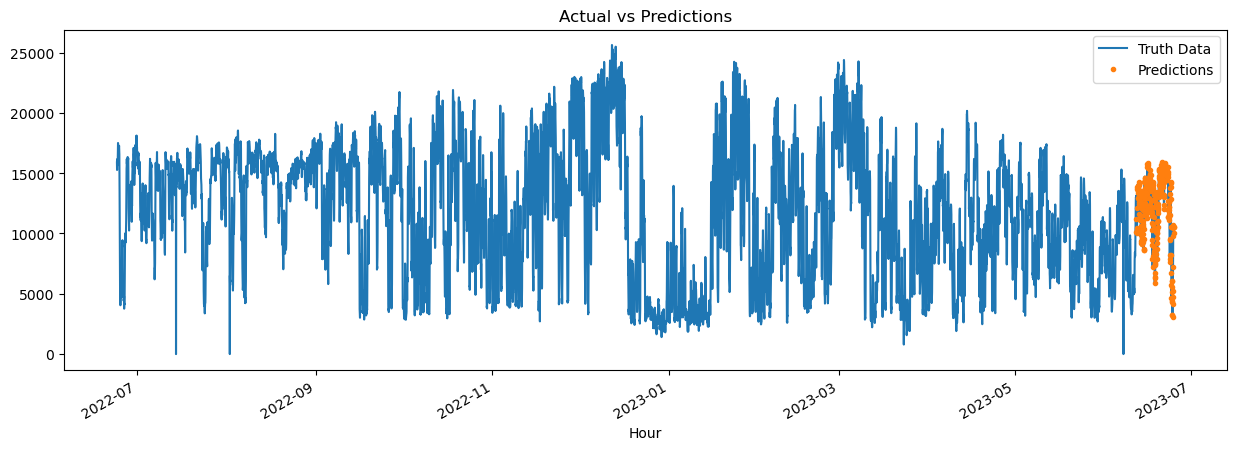

Forecasting on the test dataset for a period of two weeks : 12th June 2023 to 25th June 2023


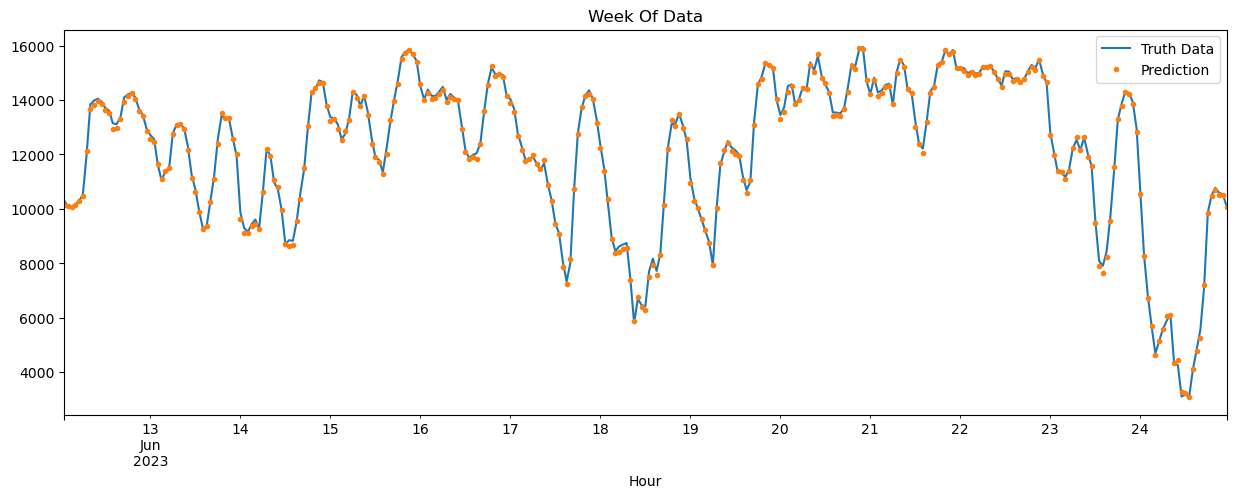


Evaluation on Test Set:
RMSE: 92.60
MAE: 72.20

Average Percentage Error (MAPE): 0.67%

Sample of Predicted vs Actual Values:

                     Actual     Predicted
Hour                                     
2023-06-12 00:00:00   11227  11163.859375
2023-06-12 01:00:00   10312  10126.527344
2023-06-12 02:00:00   10079  10088.222656
2023-06-12 03:00:00   10076  10053.504883
2023-06-12 04:00:00   10147  10155.713867
...                     ...           ...
2023-06-24 19:00:00   10502  10475.463867
2023-06-24 20:00:00   10772  10698.438477
2023-06-24 21:00:00   10591  10522.055664
2023-06-24 22:00:00   10530  10499.209961
2023-06-24 23:00:00   10098  10075.222656

[312 rows x 2 columns]


In [4]:
#Deploying
tool = TimeSeriesForecaster('/kaggle/input/energy-generation-gas-uk/energy_generation_gas.csv')
tool.plot_exploratory(tool.create_features(tool.df))
tool.train_model()
tool.plot_feature_importance()
tool.plot_predictions()
comparison_df = tool.compare_predictions()

### Feature Importance

Features play a significant role in predicting or explaining the variations in gas power generation. In our data, the most important features are:

1) **Lag 1**: It is the value of Gas(MWs) exactly one time step (in this case an hour prior) before the current timestamp. Electricity generation often follows short-term temporal dependencies. If demand or generation was high yesterday or in the previous hour, it’s very likely to be similar now — due to regular consumption patterns and grid inertia. Power generation usually doesn’t fluctuate wildly in the short term unless there’s a shock.

2) **Rolling Mean 3**: It is the average of the past 3 values of Gas(MWs) (excluding current time). It smooths out short-term fluctuations, helping the model see underlying patterns instead of noise. It helps mitigate the impact of anomalies, outliers, or sudden fluctuations that might mislead the model. Rolling averages help in capturing underlying cycles or short-term demand patterns.

3) **Lag 2**: It is the value of Gas(MWs) two time steps (in this case an hour prior) before the current timestamp. It adds momentum awareness: looking at both Lag 1 and Lag 2 helps the model detect trends vs. reversals. It is useful for deriving acceleration/deceleration in gas generation (e.g., rate of change).


## LSTMs 

LSTM stands for long short term memory. It is a model or architecture that extends the memory of recurrent neural networks(RNN). Typically, recurrent neural networks have ‘short term memory’ in that they use persistent previous information to be used in the current neural network. Essentially, the previous information is used in the present task.
They can capture long-term dependencies in the input sequence and make predictions based on the learned patterns.

Here, LSTM has been used to forecast a one-day period of hourly gas production.

We start with importing the libraries required for LSTMs


In [5]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
class LSTMForecast:
    
    def __init__(self, filepath, date_split='2023-06-24', n_input=24, n_features=1):
        self.filepath = filepath
        self.date_split = pd.to_datetime(date_split)
        self.n_input = n_input
        self.n_features = n_features
        self.scaler = MinMaxScaler()
        self.model = None

    def load_and_preprocess_data(self):
        df = pd.read_csv(self.filepath)
        df.rename(columns={'Timestamp': 'Hour'}, inplace=True)

        # Convert datetime format
        df['Hour'] = df['Hour'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z").strftime("%Y-%m-%d %H:%M"))
        df['Hour'] = pd.to_datetime(df['Hour'])
        df.set_index('Hour', inplace=True)

        self.data = df
        self.train = df.loc[df.index < self.date_split]
        self.test = df.loc[df.index >= self.date_split]
        print(f"Train shape: {self.train.shape}")
        print(f"Test shape: {self.test.shape}")

    def scale_data(self):
        self.scaler.fit(self.train)
        self.scaled_train = self.scaler.transform(self.train)
        self.scaled_test = self.scaler.transform(self.test)

    def create_generator(self):
        self.generator = TimeseriesGenerator(self.scaled_train, self.scaled_train,
                                             length=self.n_input, batch_size=1)
     
    def build_model(self):
        self.model = Sequential()
        self.model.add(LSTM(100, activation='relu', input_shape=(self.n_input, self.n_features)))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')
        self.model.summary()

    def train_model(self, epochs=10):
        self.model.fit(self.generator, epochs=epochs)
        self.loss_per_epoch = self.model.history.history['loss']

        plt.figure(figsize=(12, 4))
        plt.xticks(np.arange(0, epochs + 1, 1))
        plt.plot(range(len(self.loss_per_epoch)), self.loss_per_epoch)
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def predict(self):
        print("Generating predictions...")
        test_predictions = []
        current_batch = self.scaled_train[-self.n_input:].reshape((1, self.n_input, self.n_features))

        for i in range(len(self.test)):
            current_pred = self.model.predict(current_batch)[0]
            test_predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        self.test_predictions = np.array(test_predictions)
        self.true_predictions = self.scaler.inverse_transform(self.test_predictions)
        self.test['Predictions'] = self.true_predictions
        self.test[['Gas(MWs)', 'Predictions']].plot(figsize=(12, 6))
        plt.title("Actual vs Predicted Gas Generation")
        plt.show()

    def evaluate(self):
        rmse = np.sqrt(mean_squared_error(self.test['Gas(MWs)'], self.test['Predictions']))
        print(f"RMSE: {rmse:.2f}")

        def mean_absolute_percentage_error(y_true, y_pred): 
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            nonzero = y_true != 0
            return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

        mape = mean_absolute_percentage_error(self.test['Gas(MWs)'], self.test['Predictions'])
        print(f"MAPE: {mape:.2f}%")

Train shape: (8758, 1)
Test shape: (24, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
8734/8734 [==============================] - 87s 10ms/step - loss: 0.0041
Epoch 2/12
8734/8734 [==============================] - 85s 10ms/step - loss: 0.0016
Epoch 3/12
8734/8734 [==============================] - 85s 10ms/step - loss: 0.0015
Epoch 4/12
8734/8734 [==============================] - 86s 10ms/step - loss: 0.0014
Epoch 5/12
8734/8734 [==============================] - 84s 10ms/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 24ms/step


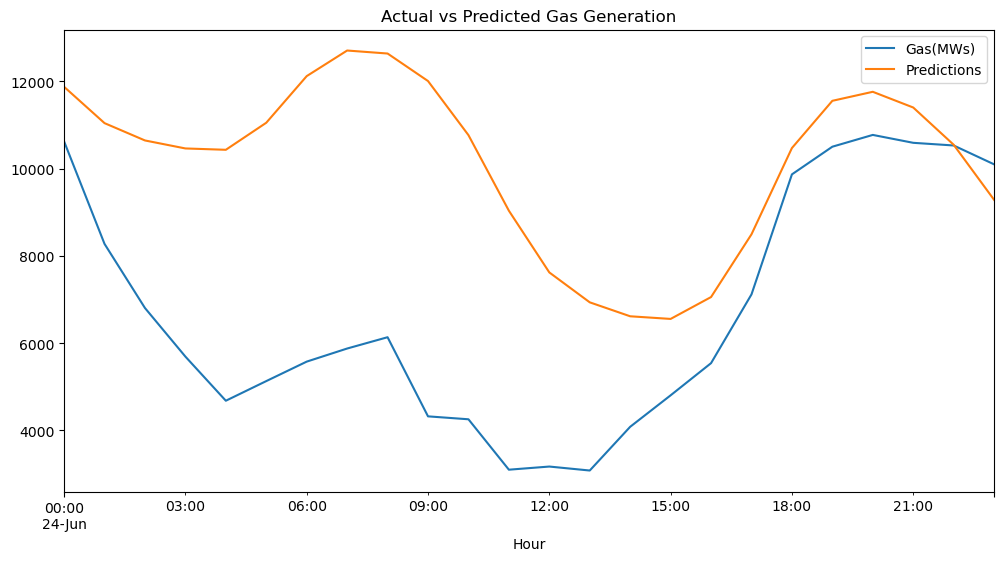

RMSE: 4257.82
MAPE: 72.33%


In [7]:
model = LSTMForecast('/kaggle/input/energy-generation-gas-uk/energy_generation_gas.csv')
model.load_and_preprocess_data()
model.scale_data()
model.create_generator()
model.build_model()
model.train_model(epochs=12)
model.predict()
model.evaluate()